In [ ]:
!wget https://www.dropbox.com/s/9w8nmj791c9ogsx/data_upload_v3.zip?dl=0

In [126]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense
from keras.optimizers import SGD

In [ ]:
!unzip data_upload_v3.zip

In [10]:
!ls

data_upload_v3	data_upload_v3.zip  sample_data


In [114]:
def load_images_from_folder(folder):
    print("Loading from folder: ", os.path.basename(folder))
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img= cv2.resize(img, (150,150))
        if img is not None:
            images.append(img)
            if os.path.basename(folder) != 'covid':
              labels.append(0)
            elif os.path.basename(folder) == 'covid':
              labels.append(1)
    return images, labels

In [53]:
train_pos = "/content/data_upload_v3/train/covid"
train_neg = "/content/data_upload_v3/train/non"

img_train_pos, label_train_pos = load_images_from_folder(train_pos)
img_train_neg, label_train_neg = load_images_from_folder(train_neg)

print ("Number of Training Images (Positive):   ", len(img_train_pos))
print ("Number of Training Images (Negative):   ", len(img_train_neg))

Loading from folder:  covid
Loading from folder:  non
Number of Training Images (Positive):    84
Number of Training Images (Negative):    2000


In [54]:
img_train_neg[12].shape


(150, 150, 3)

Train and Test Data has been loaded into the memory uptil now

In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"usamanadeem321","key":"b1721c990253ea4db5edb1e6a07c69c4"}'}

In [17]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [18]:
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images

 96% 89.0M/92.7M [00:03<00:00, 18.4MB/s]
100% 92.7M/92.7M [00:03<00:00, 25.4MB/s]


In [19]:
!ls

covid-19-x-ray-10000-images.zip  data_upload_v3.zip  sample_data
data_upload_v3			 kaggle.json


In [ ]:
!unzip covid-19-x-ray-10000-images.zip

In [55]:
def load_kaggle_dataset(folder):
    print("Loading from folder: ", os.path.basename(folder))
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img= cv2.resize(img, (150,150))
        if img is not None:
            images.append(img)
            if os.path.basename(folder) == 'normal':
              labels.append(0)
            elif os.path.basename(folder) == 'covid':
              labels.append(1)
    return images, labels

In [56]:
K_train_pos = "/content/dataset/covid"
K_train_neg = "/content/dataset/normal"

K_img_train_pos, K_label_train_pos = load_kaggle_dataset(K_train_pos)
K_img_train_neg, K_label_train_neg = load_kaggle_dataset(K_train_neg)

print ("Number of Training Images (Positive):   ", len(K_img_train_pos))
print ("Number of Training Images (Negative):   ", len(K_img_train_neg))

Loading from folder:  covid
Loading from folder:  normal
Number of Training Images (Positive):    70
Number of Training Images (Negative):    28


In [58]:
#join kaggle andd dropbox dataset
Training_Images_pos=img_train_pos+K_img_train_pos
Training_Images_neg=img_train_neg+K_img_train_neg
Training_Labels_pos=label_train_pos+K_label_train_pos 
Training_Labels_neg=label_train_neg+K_label_train_neg 

#join positive and negative training examples into single list 
total_training_img= Training_Images_pos+ Training_Images_neg
total_training_labels=Training_Labels_pos+Training_Labels_neg

print(len(total_training_img) )
print(len(total_training_labels) )

2182
2182


In [142]:
(X_train, X_valid, Y_train, Y_valid)= train_test_split(total_training_img, total_training_labels, test_size=0.1, random_state=20)

In [143]:
import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential


vgg16 = Sequential()
vgg16.add(Conv2D(64, kernel_size=3, padding='same', activation='relu',
                 input_shape=(150, 150, 3)))
vgg16.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Flatten())

vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(4096, activation='relu'))

# the data we are using has 2 classes
vgg16.add(Dense(2))
vgg16.add(Activation ('softmax'))
#vgg16.add(Dense(1, activation='softmax'))


In [146]:
opt = SGD(lr=0.01)
vgg16.compile(loss = "sparse_categorical_crossentropy", optimizer = 'SGD', metrics = ['accuracy'])

#vgg16.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt,     metrics = ['accuracy'])
vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 37, 37, 128)     

In [148]:
X_train= np.asarray(X_train)
#Y_train= np.asarray(Y_train)
Y_train= np.asarray(Y_train).astype('float32').reshape((-1,1))
X_valid= np.asarray(X_valid)
#Y_valid= np.asarray(Y_valid)
Y_valid= np.asarray(Y_valid).astype('float32').reshape((-1,1))



In [149]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(1963, 150, 150, 3)
(1963, 1)
(219, 150, 150, 3)
(219, 1)


In [150]:
trained = vgg16.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
31/31 [==============================] - 34s 1s/step - loss: 0.3534 - accuracy: 0.8266 - val_loss: 0.5607 - val_accuracy: 0.9498
Epoch 2/20
31/31 [==============================] - 25s 797ms/step - loss: 0.2487 - accuracy: 0.9283 - val_loss: 0.4985 - val_accuracy: 0.9498
Epoch 3/20
31/31 [==============================] - 25s 795ms/step - loss: 0.2476 - accuracy: 0.9295 - val_loss: 0.4909 - val_accuracy: 0.9498
Epoch 4/20
31/31 [==============================] - 25s 796ms/step - loss: 0.2463 - accuracy: 0.9288 - val_loss: 0.5198 - val_accuracy: 0.9498
Epoch 5/20
31/31 [==============================] - 25s 794ms/step - loss: 0.2387 - accuracy: 0.9266 - val_loss: 0.5338 - val_accuracy: 0.9498
Epoch 6/20
31/31 [==============================] - 25s 794ms/step - loss: 0.2369 - accuracy: 0.9267 - val_loss: 0.4450 - val_accuracy: 0.9498
Epoch 7/20
31/31 [==============================] - 25s 794ms/step - loss: 0.2200 - accuracy: 0.9265 - val_loss: 0.4043 - val_accuracy: 0.9498
Ep

In [151]:
#load test data
test_pos = "/content/data_upload_v3/test/covid"
test_neg = "/content/data_upload_v3/test/non/No_Finding"

img_test_pos, label_test_pos = load_images_from_folder(test_pos)
img_test_neg, label_test_neg = load_images_from_folder(test_neg)

#join positive and negative training examples into single list 
total_test_img= img_test_pos+ img_test_neg
total_test_labels=label_test_pos+label_test_neg

print(len(total_test_img) )
print(len(total_test_labels) )



Loading from folder:  covid
Loading from folder:  No_Finding
1800
1800


In [152]:
total_test_img= np.asarray(total_test_img)
total_test_labels= np.asarray(total_test_labels)
score = vgg16.evaluate(total_test_img, total_test_labels, batch_size=4)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

450/450 [==============================] - 18s 39ms/step - loss: 0.1063 - accuracy: 0.9711
Test Loss =  0.10631009936332703
Test Accuracy =  0.9711111187934875


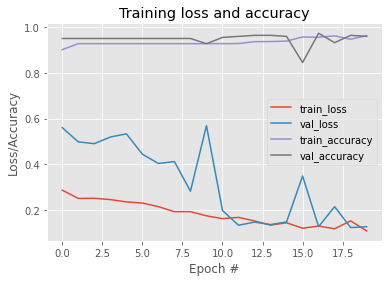

In [154]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, trained.history['loss'], label='train_loss')
plt.plot(N, trained.history['val_loss'], label='val_loss')
plt.plot(N, trained.history['accuracy'], label='train_accuracy')
plt.plot(N, trained.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()